In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from pinecone import Pinecone

from PIL import Image

In [2]:
%matplotlib inline

In [3]:
from roboto.domain import actions, datasets, files, http_delegates
from roboto.transactions.transaction_manager import TransactionManager
from roboto.http import (
        HttpClient,
        PATAuthDecoratorV1
        )
import os

### Extracting metadata from a Roboto dataset

In [4]:
import json
import logging
logger = logging.getLogger().setLevel(logging.DEBUG)
roboto_dataset_id = "ds_x45bpovnpnys"
roboto_api_url = "https://api.roboto.ai"

roboto_config_raw = open(Path("~/.roboto/config.json").expanduser(), 'r').read()
roboto_PAT = json.loads(roboto_config_raw)['default']['token']

client = HttpClient(default_auth=PATAuthDecoratorV1(pat=roboto_PAT))
delegate = http_delegates.HttpDelegates.from_client(http=client, endpoint=roboto_api_url)
transaction_manager = TransactionManager(roboto_api_url, client)

dataset = datasets.dataset.Dataset.from_id(roboto_dataset_id,\
                                           dataset_delegate=delegate.datasets,\
                                           file_delegate=delegate.files,\
                                           transaction_manager=transaction_manager)

In [10]:

# we only need text model and tokenizer because the image embeddings are already generated
# loading text only is much faster.
# but for visualizing embeddings, having the model that wraps both is more fun!
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, CLIPTextModelWithProjection, CLIPVisionModelWithProjection, CLIPImageProcessor

In [11]:
from pathlib import Path
pinecone_api_key = open(Path("~/.keys/pinecone.txt").expanduser()).read().rstrip()

In [12]:
pinecone_client = Pinecone(pinecone_api_key)

In [13]:
pinecone_client.list_indexes()

{'indexes': [{'dimension': 512,
              'host': 'actiondb-1fn1kmf.svc.aped-4627-b74a.pinecone.io',
              'metric': 'dotproduct',
              'name': 'actiondb',
              'spec': {'serverless': {'cloud': 'aws', 'region': 'us-east-1'}},
              'status': {'ready': True, 'state': 'Ready'}}]}

## Generating text embeddings

In [14]:
text_model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

vision_model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

In [15]:
text_query = "family"

tokens = tokenizer([text_query], return_tensors="pt")
embedding = text_model(**tokens).text_embeds

In [16]:
embedding
query_vec = embedding.squeeze().tolist()

## Querying Pinecone DB

In [17]:
index = pinecone_client.Index("actiondb")

In [18]:
response = index.query(
    namespace=roboto_dataset_id,
    vector=query_vec,
    top_k=3,
    include_values=True
)

In [19]:
fnames = [x['id'] for x in response['matches']]
dataset_path = Path(f"~/dev/roboto/data/{roboto_dataset_id}").expanduser()
dataset.download_files(dataset_path, include_patterns=fnames)

100.0%|█████████████████████████ | 250k/250k | 724kB/s | 00:00 | Src: ds_x45bpovnpnys/output/camera/camera_000015.jpg
100.0%|█████████████████████████ | 677k/677k | 1.67MB/s | 00:00 | Src: ds_x45bpovnpnys/output/camera/camera_000070.jpg
100.0%|█████████████████████████ | 234k/234k | 601kB/s | 00:00 | Src: ds_x45bpovnpnys/output/camera/camera_000074.jpg


## Downloading proper data from Roboto for visualizing query responses

### Text queries

In [22]:
def show_queried_image(idx):
    fname = fnames[idx]
    img_path = dataset_path / fname
    img = Image.open(img_path)
    plt.title(f"#{idx} best match for text query={text_query}")
    plt.imshow(img)

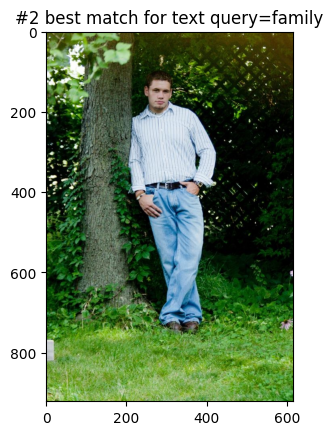

In [23]:
show_queried_image(2)

In [34]:
def query_and_show(image_or_text_query, top_k=3):
    if isinstance(image_or_text_query, str):  
        query_type = "text"
        tokens = tokenizer([text_query], return_tensors="pt")
        embedding = text_model(**tokens).text_embeds
    elif isinstance(image_or_text_query, Image.Image):
        query_type = "image"
        inputs = image_processor(images=image_or_text_query, return_tensors="pt", padding=True)
        embedding = vision_model(**inputs).image_embeds
    else:
        raise ValueError("Error: query must be str or PIL.Image")
    query_vector = embedding.squeeze().tolist()
    response = index.query(
        namespace=roboto_dataset_id,
        vector=query_vector,
        top_k=top_k,
        include_values=True
    )
    fnames = [x['id'] for x in response['matches']]
    dataset_path = Path(f"~/dev/roboto/data/{roboto_dataset_id}").expanduser()
    dataset.download_files(dataset_path, include_patterns=fnames)

    # generate pyplot figure
    if query_type == "text":
        fig, axs = plt.subplots(1, top_k)
        fig.suptitle(f"text query = {image_or_text_query}")
        for i in range(top_k):
            axs[i].set_title(f"#{i+1} match")
            fname = fnames[i]
            img_path = dataset_path / fname
            img = Image.open(img_path)
            axs[i].imshow(img)
    else:
        fig, axs = plt.subplots(1, top_k+1)
        fig.suptitle(f"image matches")
        axs[0].set_title("Query image")
        axs[0].imshow(image_or_text_query)
        for i in range(top_k):
            axs[i+1].set_title(f"#{i+1} match")
            fname = fnames[i]
            img_path = dataset_path / fname
            img = Image.open(img_path)
            axs[i+1].imshow(img)


    
    

100.0%|█████████████████████████ | 250k/250k | 831kB/s | 00:00 | Src: ds_x45bpovnpnys/output/camera/camera_000015.jpg
100.0%|█████████████████████████ | 677k/677k | 1.53MB/s | 00:00 | Src: ds_x45bpovnpnys/output/camera/camera_000070.jpg


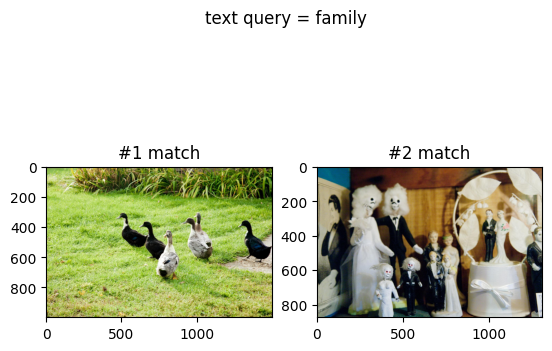

In [28]:
query_and_show("family", 2)

Unused or unrecognized kwargs: padding.
100.0%|█████████████████████████ | 110k/110k | 425kB/s | 00:00 | Src: ds_x45bpovnpnys/output/camera/camera_000122.jpg
100.0%|█████████████████████████ | 262k/262k | 782kB/s | 00:00 | Src: ds_x45bpovnpnys/output/camera/camera_000119.jpg
100.0%|█████████████████████████ | 425k/425k | 1.34MB/s | 00:00 | Src: ds_x45bpovnpnys/output/camera/camera_000057.jpg


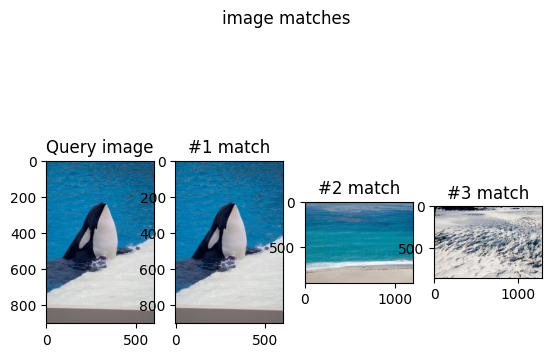

In [35]:
test_img_path = "/Users/dave/Downloads/roboto_test/GT_IMAGES/a1044-_DSC0121.jpg"
input_img = Image.open(test_img_path)
query_and_show(input_img, 3)